# Exoplanet XGBoost demo

This notebook downloads small selected-column extracts of the KOI (Kepler), TOI (TESS), and K2 tables from the NASA Exoplanet Archive, standardizes columns, trains a simple XGBoost classifier on each dataset separately, evaluates results, and finally trains a model on the concatenation (combined dataset). 

**Notes**:
- The notebook uses lightweight column selections to keep downloads small.
- Labels are mapped to a binary target: **planet (1)** vs **not-planet / false positive (0)**.
- Ambiguous/unknown dispositions are dropped.

Run all cells. If you run this in a fresh environment you may need to install packages (the first cell does that).

In [1]:

# Install required packages (only if not already installed)
# You can comment this cell out if your environment already has these packages.
import sys
!{sys.executable} -m pip install --quiet pandas scikit-learn xgboost requests matplotlib seaborn nbformat joblib
print("Packages installed/imported (or already present).")


Packages installed/imported (or already present).


'c:\Users\RAJ' is not recognized as an internal or external command,
operable program or batch file.


In [1]:

# Download selected columns for KOI, TOI, and K2 using TAP sync endpoint.
# The requests library will handle URL quoting for us.
import os, requests
from requests.utils import requote_uri

os.makedirs("data", exist_ok=True)

queries = {
    "kepler_koi": "select kepoi_name,koi_disposition,koi_pdisposition,koi_period,koi_duration,koi_prad,koi_depth,koi_model_snr from cumulative",
    "tess_toi":   "select toi,tfopwg_disp,pl_orbper,pl_trandurh,pl_trandep,pl_rade,st_teff,st_rad from toi",
    # "k2_pandc":   "select pl_name,disposition,pl_orbper,pl_trandur,pl_trandepl,pl_rade,st_teff,st_rad from k2pandc"
}

base = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?format=csv&query="

for name, q in queries.items():
    out = f"data/{name}.csv"
    if os.path.exists(out) and os.path.getsize(out) > 100:
        print(f"Skipping download (already present): {out}")
        continue
    url = base + requote_uri(q)
    print("Downloading", name, "->", out)
    r = requests.get(url, timeout=300)
    r.raise_for_status()
    open(out, "wb").write(r.content)
    print("Saved", out)
print("Downloads complete. Files in data/:", os.listdir("data"))


Skipping download (already present): data/kepler_koi.csv
Skipping download (already present): data/tess_toi.csv
Downloads complete. Files in data/: ['k2pandc.csv', 'kepler_koi.csv', 'kepler_koi_33.csv', 'kepler_koi_cumulative.csv', 'tess_toi.csv']


In [2]:

import pandas as pd
from pathlib import Path

files = {
    "KOI": Path("data/kepler_koi.csv"),
    "TOI": Path("data/tess_toi.csv"),
    # "K2": Path("data/k2_pandc.csv")
}

for k, p in files.items():
    print(f"--- {k} ---")
    if not p.exists():
        print("File missing:", p)
        continue
    df = pd.read_csv(p)
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    display(df.head(3))


--- KOI ---
Shape: (9564, 8)
Columns: ['kepoi_name', 'koi_disposition', 'koi_pdisposition', 'koi_period', 'koi_duration', 'koi_prad', 'koi_depth', 'koi_model_snr']


,kepoi_name,koi_disposition,koi_pdisposition,koi_period,koi_duration,koi_prad,koi_depth,koi_model_snr
0,K00752.01,CONFIRMED,CANDIDATE,9.488036,2.9575,2.26,615.8,35.8
1,K00752.02,CONFIRMED,CANDIDATE,54.418383,4.5070,2.83,874.8,25.8
2,K00753.01,CANDIDATE,CANDIDATE,19.899140,1.7822,14.60,10829.0,76.3


--- TOI ---
Shape: (7703, 8)
Columns: ['toi', 'tfopwg_disp', 'pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'st_teff', 'st_rad']


,toi,tfopwg_disp,pl_orbper,pl_trandurh,pl_trandep,pl_rade,st_teff,st_rad
0,1049.01,KP,2.180528,2.969175,16340.135320,16.808853,6599.0,1.27146
1,105.01,KP,2.184667,2.865280,11708.022855,13.702853,5630.0,1.23824
2,1050.01,KP,3.735484,4.142000,17030.000000,21.231500,6650.0,1.57000


In [3]:

# We'll create a function to standardize columns for each table to a common schema:
# Unified columns: ['id','label','period','duration','depth','prad','snr','st_teff','st_rad']
# label: 1 = planet (confirmed or candidate), 0 = false positive / not planet
import numpy as np
import pandas as pd

def standardize_koi(df):
    out = pd.DataFrame()
    out['id'] = df.get('kepoi_name')
    disp = df.get('koi_disposition').astype(str).str.upper()
    out['label'] = disp.replace({
        'CANDIDATE': 1, 'CONFIRMED': 1, 'FALSE POSITIVE': 0, 'FALSE_POSITIVE': 0
    })
    out['period'] = pd.to_numeric(df.get('koi_period'), errors='coerce')
    out['duration'] = pd.to_numeric(df.get('koi_duration'), errors='coerce')
    out['depth'] = pd.to_numeric(df.get('koi_depth'), errors='coerce')
    out['prad'] = pd.to_numeric(df.get('koi_prad'), errors='coerce')
    out['snr'] = pd.to_numeric(df.get('koi_model_snr'), errors='coerce')
    out['st_teff'] = np.nan
    out['st_rad'] = np.nan
    return out

def standardize_toi(df):
    out = pd.DataFrame()
    out['id'] = df.get('toi')
    disp = df.get('tfopwg_disp').astype(str).str.upper()
    out['label'] = disp.replace({
        'PC': 1, 'KP': 1, 'CONFIRMED': 1, 'CANDIDATE': 1,
        'FP': 0, 'FALSE POSITIVE': 0
    })
    out['period'] = pd.to_numeric(df.get('pl_orbper'), errors='coerce')
    out['duration'] = pd.to_numeric(df.get('pl_trandurh'), errors='coerce')
    out['depth'] = pd.to_numeric(df.get('pl_trandep'), errors='coerce')
    out['prad'] = pd.to_numeric(df.get('pl_rade'), errors='coerce')
    out['snr'] = np.nan
    out['st_teff'] = pd.to_numeric(df.get('st_teff'), errors='coerce')
    out['st_rad'] = pd.to_numeric(df.get('st_rad'), errors='coerce')
    return out

def standardize_k2(df):
    out = pd.DataFrame()
    out['id'] = df.get('pl_name')
    disp = df.get('disposition').astype(str).str.upper()
    out['label'] = disp.replace({
        'CANDIDATE': 1, 'CONFIRMED': 1, 'FALSE POSITIVE': 0, 'FALSE_POSITIVE': 0, 'FALSE_POSITIVE?': 0
    })
    out['period'] = pd.to_numeric(df.get('pl_orbper'), errors='coerce')
    out['duration'] = pd.to_numeric(df.get('pl_trandur'), errors='coerce')
    out['depth'] = pd.to_numeric(df.get('pl_trandepl'), errors='coerce')
    out['prad'] = pd.to_numeric(df.get('pl_rade'), errors='coerce')
    out['snr'] = np.nan
    out['st_teff'] = pd.to_numeric(df.get('st_teff'), errors='coerce')
    out['st_rad'] = pd.to_numeric(df.get('st_rad'), errors='coerce')
    return out

# Read and standardize
df_koi = pd.read_csv("data/kepler_koi.csv") if os.path.exists("data/kepler_koi.csv") else pd.DataFrame()
df_toi = pd.read_csv("data/tess_toi.csv") if os.path.exists("data/tess_toi.csv") else pd.DataFrame()
df_k2  = pd.read_csv("data/k2_pandc.csv") if os.path.exists("data/k2_pandc.csv") else pd.DataFrame()

std_koi = standardize_koi(df_koi) if not df_koi.empty else pd.DataFrame()
std_toi = standardize_toi(df_toi) if not df_toi.empty else pd.DataFrame()
std_k2  = standardize_k2(df_k2) if not df_k2.empty else pd.DataFrame()

print('KOI standardized shape:', std_koi.shape)
print('TOI standardized shape:', std_toi.shape)
print('K2 standardized shape:', std_k2.shape)

for name, df in [('KOI', std_koi), ('TOI', std_toi), ('K2', std_k2)]:
    if df.empty:
        continue
    print(name, "labels value counts (including NaN):")
    print(df['label'].value_counts(dropna=False))


KOI standardized shape: (9564, 9)
TOI standardized shape: (7703, 9)
K2 standardized shape: (0, 0)
KOI labels value counts (including NaN):
label
0    4839
1    4725
Name: count, dtype: int64
TOI labels value counts (including NaN):
label
1      5262
0      1197
CP      684
APC     462
FA       98
Name: count, dtype: int64


C:\Users\RAJ DAVE\AppData\Local\Temp\ipykernel_25016\2786402607.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  out['label'] = disp.replace({



Training on KOI


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['st_teff' 'st_rad']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['st_teff' 'st_rad']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['st_teff' 'st_rad']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


== Results for KOI (test set) ==

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       968
           1       0.81      0.81      0.81       945

    accuracy                           0.81      1913
   macro avg       0.81      0.81      0.81      1913
weighted avg       0.81      0.81      0.81      1913

ROC AUC: 0.8991544230180594


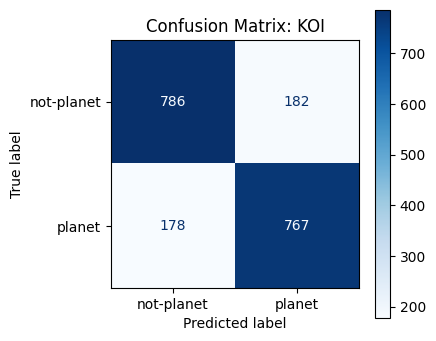


Training on TOI


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['snr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


== Results for TOI (test set) ==

              precision    recall  f1-score   support

           0       0.55      0.36      0.44       239
           1       0.87      0.93      0.90      1053

    accuracy                           0.83      1292
   macro avg       0.71      0.65      0.67      1292
weighted avg       0.81      0.83      0.81      1292

ROC AUC: 0.797303579730358


c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['snr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\RAJ DAVE\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_base.py:577: UserWarning: Skipping features without any observed values: ['snr']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


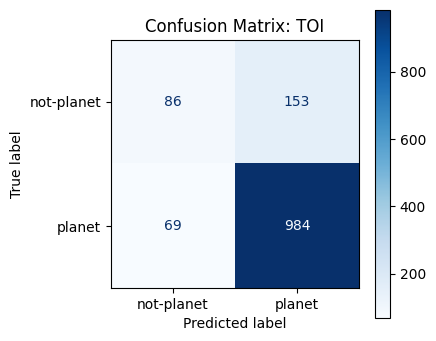

K2 dataset missing - skipping


In [4]:

# Train a simple XGBoost classifier per dataset
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

def train_and_eval(df_std, name='dataset'):
    df = df_std.dropna(subset=['label']).copy()
    df = df[df['label'].isin([0,1])].copy()
    if df.shape[0] < 50:
        print(name, "too few rows after filtering:", df.shape[0])
        return None
    features = ['period','duration','prad','depth','st_teff','st_rad','snr']
    X = df[features].copy()
    y = df['label'].astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('xgb', XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0))
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps['xgb'], "predict_proba") else None
    print(f"== Results for {name} (test set) ==\n")
    print(classification_report(y_test, y_pred))
    if len(y_test.unique())==2 and y_proba is not None:
        try:
            auc = roc_auc_score(y_test, y_proba)
            print('ROC AUC:', auc)
        except Exception as e:
            print('ROC AUC error:', e)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not-planet','planet'])
    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.show()
    return pipe, (X_test, y_test, y_pred)

models = {}
for name, dfstd in [('KOI', std_koi), ('TOI', std_toi), ('K2', std_k2)]:
    if dfstd.empty:
        print(name, "dataset missing - skipping")
        continue
    print('\nTraining on', name)
    res = train_and_eval(dfstd, name=name)
    if res:
        models[name] = res[0]


Combined shape before dropna label filter: (17267, 9)
Combined shape after label filtering: (16023, 9)
Combined shape after dropping rows with <2 features present: (16023, 9)
== Results for COMBINED (test set) ==

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1207
           1       0.83      0.88      0.86      1998

    accuracy                           0.82      3205
   macro avg       0.81      0.80      0.80      3205
weighted avg       0.82      0.82      0.82      3205

ROC AUC: 0.8771126138566073


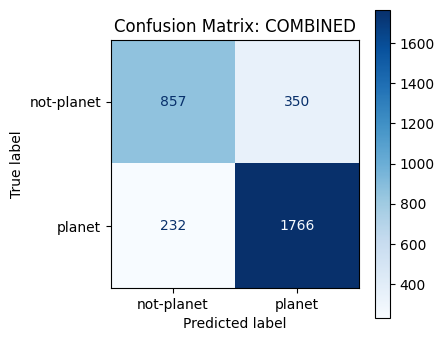

In [5]:

# Combine standardized datasets (drop duplicates by id if present)
import pandas as pd
combined = pd.concat([d for d in [std_koi, std_toi, std_k2] if not d.empty], ignore_index=True)
print('Combined shape before dropna label filter:', combined.shape)
combined = combined.dropna(subset=['label'])
combined = combined[combined['label'].isin([0,1])].copy()
print('Combined shape after label filtering:', combined.shape)
featcols = ['period','duration','prad','depth','st_teff','st_rad','snr']
combined = combined.dropna(thresh=2, subset=featcols)
print('Combined shape after dropping rows with <2 features present:', combined.shape)

combined_model = None
if combined.shape[0] >= 50:
    combined_model, _ = train_and_eval(combined, name='COMBINED')
    models['COMBINED'] = combined_model
else:
    print('Combined dataset too small to train after filtering.')


In [6]:

# Save models to disk
import joblib, os
os.makedirs('models', exist_ok=True)
for k, v in models.items():
    fname = f"models/xgb_{k.lower()}.joblib"
    joblib.dump(v, fname)
    print('Saved', fname)

print('\nDone. Models saved to models/*.joblib.')


Saved models/xgb_koi.joblib


Saved models/xgb_toi.joblib
Saved models/xgb_combined.joblib

Done. Models saved to models/*.joblib.
